In [65]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.nddata import Cutout2D

import regions

import random as rand

In [66]:
def get_cutout(filename, position, l, w, format='fits'):
    if format == 'fits':
        try: 
            hdu = fits.open(filename)
            data = np.squeeze(hdu['SCI'].data)
            head = hdu['SCI'].header
        except: 
            hdu = fits.open(filename)[0]
            data = np.squeeze(hdu.data)
            head = hdu.header
    elif format == 'casa':
        hdu = SpectralCube.read(filename, format='casa').hdu
        data = np.squeeze(hdu.data)
        head = hdu.header
    #pixel_scale = head['PIXSCALE']*u.arcsec/u.pix
    ww = WCS(head).celestial
    size = (l, w)
    #((l/pixel_scale).to(u.pix), (w/pixel_scale).to(u.pix))
    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout

In [67]:
basepath = '/orange/adamginsburg/jwst/cloudc/'
fn = f'{basepath}/F466N/pipeline/jw02221002001_04201_00001_nrcblong_destreak_o002_crf.fits'

In [68]:
hdu = fits.open(fn)
dat = hdu['SCI'].data
head = hdu['SCI'].header

In [115]:
head

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    60049.64059627488 / [d] exposure start time in MJD                 
MJD-AVG =    60049.64090694531 / [d] exposure mid-point in MJD                  
MJD-END =    60049.64121761574 / [d] exposure end time in MJD                   
TDB-BEG =    60049.63694340633 / [d] TDB time of exposure start in MJD          
TDB-MID =    60049.637254077

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.363789 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'.
  warnings.warn(


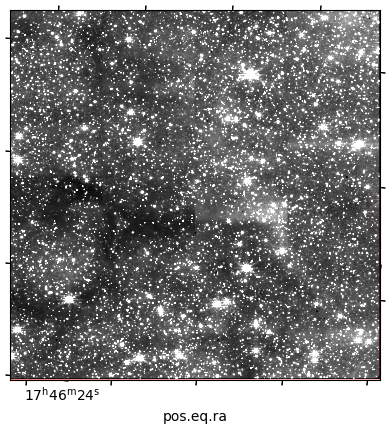

In [78]:
ax = plt.subplot(projection=WCS(head))
ax.imshow(np.nan_to_num(dat), origin='lower', cmap='gray', vmin=0, vmax=50)

center = WCS(head).pixel_to_world(head['NAXIS1']/2, head['NAXIS2']/2)#SkyCoord.from_header(head)

radius = 0.5 * np.max(proj_plane_pixel_scales(WCS(head)))*u.deg * head['NAXIS1']

reg = regions.RectangleSkyRegion(center, width=2*radius, height=2*radius, angle=5.5*u.deg)

reg.to_pixel(WCS(head)).plot(ax=ax, edgecolor='red')

In [93]:
cat = Table.read(f'{basepath}/F466N/f466n_merged_daophot_basic.fits')

cat_in = cat[reg.contains(cat['skycoord_centroid'], wcs=WCS(head))]

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.363789 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'.
  warnings.warn(


In [102]:
cat.columns

<TableColumns names=('id','group_id','group_size','local_bkg','x_init','y_init','flux_init','x_fit','y_fit','flux_fit','x_err','y_err','flux_err','npixfit','qfit','cfit','flags','skycoord_centroid')>

In [94]:
coords_ref = cat_in['skycoord_centroid']

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.363789 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.186783 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298882177.580 from OBSGEO-[XYZ]'.
  warnings.warn(


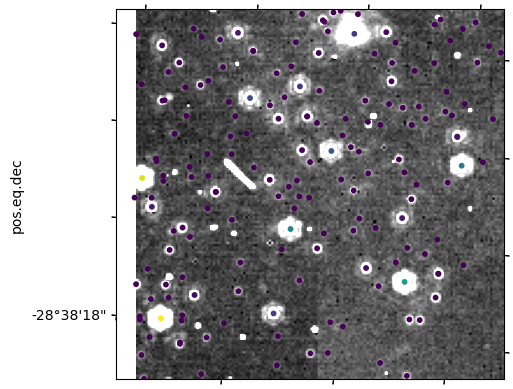

In [106]:
cutout = get_cutout(fn, center, 10*u.arcsec, 10*u.arcsec)

ax = plt.subplot(projection=cutout.wcs)
ax.imshow(np.nan_to_num(cutout.data), origin='lower', cmap='gray', vmin=0, vmax=50)

reg_smo = regions.RectangleSkyRegion(center, width=10*u.arcsec, height=10*u.arcsec, angle=5.5*u.deg)

cat_smo_in = cat_in[reg_smo.contains(coords_ref, wcs=cutout.wcs)]
crds_in = cat_smo_in['skycoord_centroid']
qf = cat_smo_in['qfit']
flux = cat_smo_in['flux_fit']

#ax.scatter(crds_in.ra, crds_in.dec, transform=ax.get_transform('world'), s=10, c=qf, cmap='viridis', vmin=0, vmax=0.4)
ax.scatter(crds_in.ra, crds_in.dec, transform=ax.get_transform('world'), s=10, c=flux, cmap='viridis', vmin=2000)

In [124]:
def make_table(coords, flux):
    cat = Table([coords, flux], names=('skycoord_centroid', 'flux'))
    return cat

def generate_random_catalog(cat):
    crds_in = cat['skycoord_centroid']
    flux_in = cat['flux']
    noise_ra = np.random.normal(loc=0, scale=0.1, size=len(crds_in.ra))
    noise_dec = np.random.normal(loc=0, scale=0.1, size=len(crds_in.dec))
    noise_flux = np.random.normal(loc=0, scale=0.1, size=len(flux_in))

    crds_in_ra_random = crds_in.ra + noise_ra*u.arcsec
    crds_in_dec_random = crds_in.dec + noise_dec*u.arcsec
    crds_in_flux_random = flux_in*u.MJy + noise_flux*u.Jy

    crds_in_random = SkyCoord(ra=crds_in_ra_random, dec=crds_in_dec_random, unit='deg')

    cat_random = make_table(crds_in_random, crds_in_flux_random)
    return cat_random

flux_in = cat_smo_in['flux_fit']
crds_in = cat_smo_in['skycoord_centroid']
cat_ex = make_table(crds_in, flux_in)
cat_random = generate_random_catalog(cat_ex)

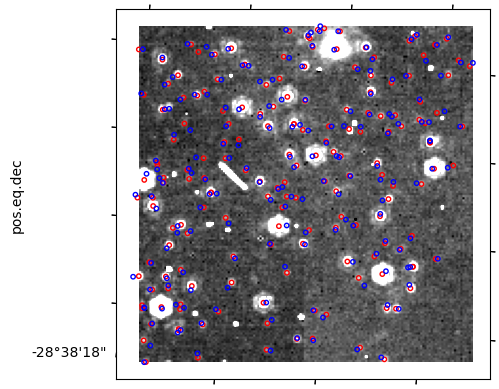

In [125]:
ax = plt.subplot(projection=cutout.wcs)
ax.imshow(np.nan_to_num(cutout.data), origin='lower', cmap='gray', vmin=0, vmax=50)

ax.scatter(crds_in.ra, crds_in.dec, transform=ax.get_transform('world'), s=10, facecolor='none', edgecolor='red', marker='o')

ax.scatter(cat_random['skycoord_centroid'].ra, cat_random['skycoord_centroid'].dec, transform=ax.get_transform('world'), s=10, facecolor='none', edgecolor='blue', marker='o')

In [135]:
np.array([cat_ex['skycoord_centroid'].ra, cat_ex['skycoord_centroid'].dec, cat_ex['flux']]).T.shape

(173, 3)

In [136]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=2)